# Imports

In [ ]:
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2
from cv2 import imread, createCLAHE

from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [58]:
dataset_folder = '/home/joffrey/Documents/projects/pneumonia/dataset/'
base_folder = dataset_folder + '/chest_xray/'

TRAIN_FOLDER = base_folder + 'train'
TEST_FOLDER = base_folder + 'test'

# Data transformation

In [59]:
categories = [
    "NORMAL",
    "PNEUMONIA"
]

### Create image labels dataframe

We can't load all images on the RAM, labelise them and save them directly. However, we can labelise them through their path, and load them one by one later.

In [60]:
df = pd.DataFrame(columns=['label', 'path'])

In [61]:
folders = [TRAIN_FOLDER, TEST_FOLDER]

# Loop through "Normal" and "Pneumonia" from train and test folder
for folder in folders:
    for label in range(len(categories)):
        
        # Get the current directory
        category = categories[label]
        directory = f"{folder}/{category}/"
        
        # Loop through all file in this directory
        for file_ in os.listdir(directory):
            
            full_path = directory + '/' + file_
            df = df.append({'label': label, 'path': full_path}, ignore_index=True)

In [62]:
df

,label,path
0,0,/home/joffrey/Documents/projects/pneumonia/dat...
1,0,/home/joffrey/Documents/projects/pneumonia/dat...
2,0,/home/joffrey/Documents/projects/pneumonia/dat...
3,0,/home/joffrey/Documents/projects/pneumonia/dat...
4,0,/home/joffrey/Documents/projects/pneumonia/dat...
...,...,...
5835,1,/home/joffrey/Documents/projects/pneumonia/dat...
5836,1,/home/joffrey/Documents/projects/pneumonia/dat...
5837,1,/home/joffrey/Documents/projects/pneumonia/dat...
5838,1,/home/joffrey/Documents/projects/pneumonia/dat...


### Transform dataframe to h5py

In [63]:
h5_file_path = dataset_folder + 'chest_xray_10.h5'

In [64]:
def write_df_as_hdf(out_path, dataframe, comp='gzip'):
    
    # Create a h5 file, loop trought the content of the dataframe
    with h5py.File(out_path, 'w') as h5:
        for columns, content in tqdm(dataframe.to_dict().items()):
            
            try:
                serialized_data = np.stack(content.values(), 0)
                
                try:
                    h5.create_dataset(columns, data=serialized_data, compression=comp)
                    
                except TypeError as e:
                    
                    try:
                        h5.create_dataset(columns, data=serialized_data.astype(np.string_), compression=comp)
                        
                    except TypeError as e2:
                        print('%s could not be added to hdf5, %s' % (
                            columns, repr(e), repr(e2)))
                        
            except ValueError as e:
                print('%s could not be created, %s' % (columns, repr(e)))
                all_shape = [np.shape(x) for x in content.values()]
                warn('Input shapes: {}'.format(all_shape))

In [65]:
write_df_as_hdf(h5_file_path, df[['label']])

  0%|          | 0/1 [00:00<?, ?it/s]/home/joffrey/.pyenv/versions/pneumonia/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 1/1 [00:00<00:00, 57.87it/s]


In [66]:
# Show what is inside
with h5py.File(h5_file_path, 'r') as h5_data:
    
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

label (5840,) int64


### Transform image to h5py

In [67]:
from skimage import transform

RESIZE_DIM = (1000, 1300)

def imread_and_normalize(img_path):
    
    # Read the image as int9
    img_data = np.mean(imread(img_path), 2).astype(np.uint8)
    
    # Normalize and return
    n_img = (255 * transform.resize(img_data, RESIZE_DIM, mode = 'constant')).clip(0, 255).astype(np.uint8)
    return np.expand_dims(n_img, -1)

In [68]:
CROP_DIM = (640, 850)

def crop_center(img: np.array):
    
    h, w = CROP_DIM
    
    center = img.shape[0] / 2, img.shape[1] / 2
    x = center[1] - w/2
    y = 90 + center[0] - h/2
    
    return img[int(y):int(y+h), int(x):int(x+w)]

In [69]:
OUT_SIZE = (32, 42)

def resize_img(img: np.array):
    return transform.resize(img, OUT_SIZE, mode = 'constant')

OU_SIZE = (10, 14)

def maxpool(img: np.array):
    return 

Run a test:

<class 'numpy.ndarray'>


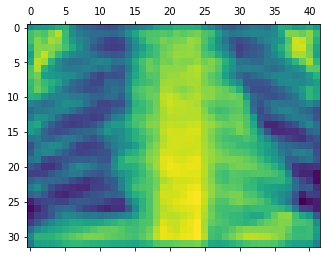

In [34]:
image = imread_and_normalize(df['path'].values[0])
cropped_img = crop_center(image)
resized_img = resize_img(cropped_img)

print(type(resized_img))
plt.matshow(resized_img)

In [35]:
# Preallocate output
# img_array = np.zeros((df.shape[0],) + OUT_SIZE + (1,), dtype=np.uint8)
img_array = []

# Set to TRUE to hard preallocate
# Warning: May cause system crash !
if False:
    img_array = np.random.uniform(0, 255, size = (df.shape[0],)+ OUT_SIZE +(1,)).astype(np.uint8)

In [36]:
for i, path in enumerate(tqdm(df['path'].values)):
    img_array.append(resize_img(crop_center(imread_and_normalize(path))))

100%|██████████| 5840/5840 [10:59<00:00,  8.86it/s]


In [37]:
with h5py.File(h5_file_path, 'a') as h5_data:
    h5_data.create_dataset('images', data = np.array(img_array), compression = 'gzip')

In [38]:
with h5py.File(h5_file_path, 'r') as h5_data:
    for c_key in h5_data.keys():
        print(c_key, h5_data[c_key].shape, h5_data[c_key].dtype)

images (5840, 32, 42, 1) float64
label (5840,) int64
